In [14]:
# Dependencies
import requests
import datetime
import pandas as pd
import numpy as np
from IPython import display # For updating the cell dynamically
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.colors import ListedColormap
from math import ceil

In [2]:
"""
Adapted from from Stefanie Molin: Hands-On-Data-Analysis-With-Pandas. Available at:
https://github.com/stefmolin/Hands-On-Data-Analysis-with-Pandas/tree/master/ch_04
"""

def make_request(endpoint, payload=None):
    """
    Make a request to a specific endpoint on the weather API
    passing headers and optional payload.
    
    Parameters:
        - endpoint: The endpoint of the API you want to 
                    make a GET request to.
        - payload: A dictionary of data to pass along 
                   with the request.
    
    Returns:
        Response object.
    """
    return requests.get(
        f'https://www.ncdc.noaa.gov/cdo-web/api/v2/{endpoint}',
        headers={
            'token': 'DOENrJHGTEFUiebNMWZLniFJXUGTiVxr'
        },
        params=payload
    )

In [23]:
def GetData(stationid, startYear, endYear):
    """
    This function grabs min and max daily temperature data for a chosen station from NOAA GHCND climate dataset.
    It then calculates the average temperature over a chosen date range.
    
    Parameters:
        - stationid:  A string of the GHCND station identifier
                      Example : GHCND:UK000000000
        - startYear:  Integer of first year of date range
        - endYear:    Integer of last year of date range
    
    Returns:
        Pandas dataframe of daily mean temperatures (TAvg)
    """

    start = startYear
    end = endYear

    results = []

    while start <= end:
        
        currentStart = datetime.date(start, 1, 1)
        currentEnd = datetime.date(start + 1, 1, 1)
        
        # Update the cell with status information
        display.clear_output(wait=True)
        display.display(f'Gathering data for {str(currentStart)}')
        
        response = make_request('data', 
            {
                'datasetid' : 'GHCND', # Global Historical Climatology Network - Daily (GHCND) dataset
                'datatypeid' : 'TMAX', # Max Temp
                'stationid' : stationid, # Station ID
                'startdate' : currentStart,
                'enddate' : currentEnd,
                'units' : 'metric', # Temperature units are degrees C
                'limit' : 1000 # Return maximum allowed
            })

        if response.ok:
            # We extend the list instead of appending to avoid getting a nested list
            results.extend(response.json()['results'])
            
        response = make_request('data', 
            {
                'datasetid' : 'GHCND', # Global Historical Climatology Network - Daily (GHCND) dataset
                'datatypeid' : 'TMIN', # Min Temp
                'stationid' : stationid, # Station ID
                'startdate' : currentStart,
                'enddate' : currentEnd,
                'units' : 'metric', # Temperature units are degrees C
                'limit' : 1000 # Return maximum allowed
            })
        
        if response.ok:
            # We extend the list instead of appending to avoid getting a nested list
            results.extend(response.json()['results'])

        # Update the current date to avoid an infinite loop
        start += 1
        
    # Convert to Pandas Dataframe and tidy
    df = pd.DataFrame(results)
    del df["attributes"] # Needless
    df["date"] = df["date"].str[:10] # Get ride of time stamp
    df["date"] = df.apply(lambda x: datetime.datetime.strptime(x["date"], "%Y-%m-%d"), axis = 1) # Convert dates to datetime format
    df = df.groupby("date").mean() # Take mean of Tmax and Tmin
    df.rename(columns = {"value" : "TAvg"}, inplace = True)
           
    # Re-sample at chosen frequency and return dataframe
    return df[:-1]

In [190]:
# Define parameters
startYear = 1900
endYear = 2019
stationid = "GHCND:UK000003026" # Stornoway, UK

In [ ]:
# Get dataframe
df = GetData(stationid, startYear, endYear)

'Gathering data for 1976-01-01'

In [ ]:
df.to_csv("stornoway_uk.csv")

In [166]:
def plotData(df, startDate, endDate, sampleFreq):
    """
    This function resamples the daily temperature data at a chosen frequency and over the chosen time range.
    It then plots the corresponding climate stripes and time series.
    Warming stripes plot adapted from https://matplotlib.org/matplotblog/posts/warming-stripes/
    
    Parameters:
        - startDate:  String of starting date, e.g. '1955-01-01'
        - endDate:    String of end date, e.g. '1970-12-31'
        - sampleFreq: String of pandas DateOffset alias: 'AS' = Yearly, 'MS' = Monthly, 'W' = weekly
                      For documentation, see https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html
    
    Returns:
        Plot of climate stripes and time series of mean temperatures (TAvg)
    """
    
    # Resample data
    df = df[startDate : endDate].resample(sampleFreq).mean()
    
    # Get mean over reference period
    reference = df["TAvg"].mean()
    cmap = ListedColormap([
        '#08306b', '#08519c', '#2171b5', '#4292c6',
        '#6baed6', '#9ecae1', '#c6dbef', '#deebf7',
        '#fee0d2', '#fcbba1', '#fc9272', '#fb6a4a',
        '#ef3b2c', '#cb181d', '#a50f15', '#67000d',
    ])
    
    # Set figure
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_axes([0, 0, 1, 1])
    
    # Set limit values
    xmin = df.index[0].year
    xmax = df.index[-1].year
    ymin = int(df["TAvg"].min()) - 1
    ymax = int(df["TAvg"].max()) + 1
    
    # create a collection with a rectangle for each year
    col = PatchCollection([
        Rectangle((y, ymin), 1, ymax-ymin)
        for y in np.linspace(df.index[0].year, df.index[-1].year, len(df.index))
    ])
    
    # set data, colormap and color limits
    col.set_array(df["TAvg"])
    col.set_cmap(cmap)
    col.set_clim(ymin, ymax)
    ax.add_collection(col)
                
    # Plot time series
    ax.plot(np.linspace(xmin + (xmax-xmin)/(len(df.index))/2., xmax - (xmax-xmin)/(len(df.index))/2., len(df.index)-1), df["TAvg"][:-1], color = 'yellow', 
            marker='o', mec='#ffffcc', linewidth=4, markersize=16, zorder = 1)
    
    # Set limits
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin, xmax)
    ax.xaxis.set_ticks(np.arange(xmin, xmax+1, 1))
    ax.yaxis.set_ticks(np.arange(ymin, ymax, 1))
    
    # Final touches
    plt.xticks(rotation=45)
    ax.set_xlabel('Year', fontsize=24)
    ax.set_ylabel('Temperature [$^\degree$C]', fontsize=24)
    plt.title('Warming Stripes', fontsize=40, pad = 20)
    
    plt.show()

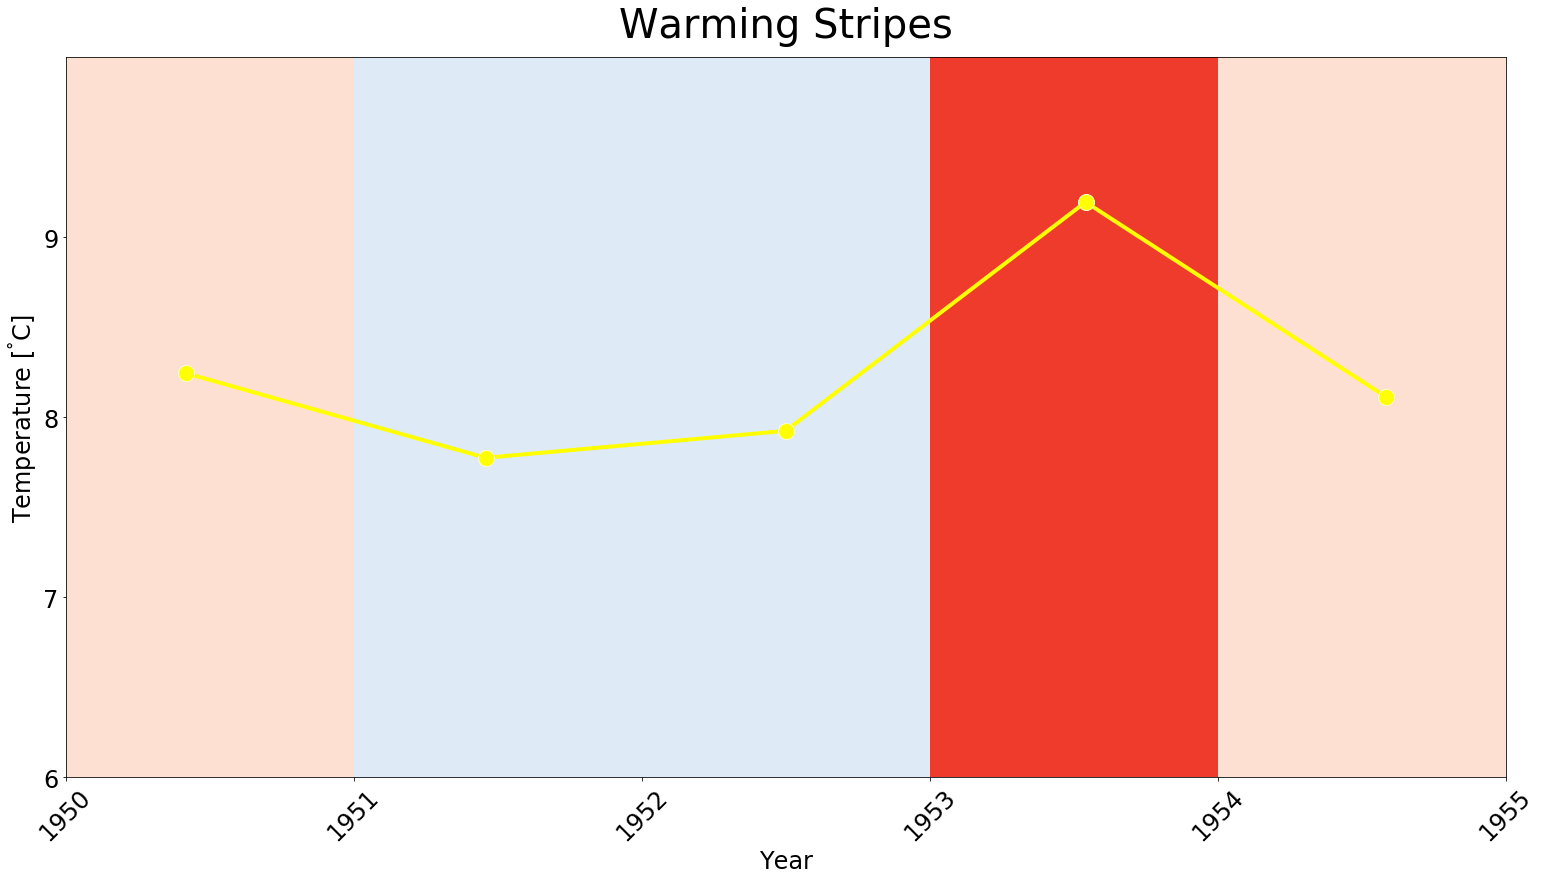

In [182]:
plotData(df, '1950-01-01', '1955-12-31', 'AS')